# The Capital Problem
Notebook to show the the consequences of not properly understanding the lifetime dynamics of the capital requirements of derivatives.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class IR_Swap:
    def __init__(self, notional, start_year, end_year, fixed_rate, direction):
        self.notional = notional 
        self.start = start_year
        self.end = end_year
        self.fixed = fixed_rate
        self.direction = direction
    def pv(self, curve, date = 0):
        cf = self.cashflows(curve, date)
        pv = 0
        year = 1
        for flow in cf:
            pv += curve.df(year)*cf[year-1]
            year += 1
        pv = pv / curve.df(date)
        return pv
    def cashflows(self, curve, date = 0):
        cf = []
        if self.direction == "p":
            direction = -1
        elif self.direction == "r":
            direction = 1
        else:
            direction = None
        for year in range(1, self.end + 1):
            if year <= self.start or year <= date:
                cf.append(0)
            else:
                flt = curve.forward(year)
                fixed = self.fixed
                notl = self.notional
                cf.append(direction * (fixed - flt) * notl)
        return cf

    def pv_mc(self, model_output, date = 0):
        model_output = np.array(model_output)
        cf = []
        if self.direction == "p":
            direction = -1
        elif self.direction == "r":
            direction = 1
        else:
            direction = None
        for year in range(1, self.end + 1):
            if year <= self.start or year <= date:
                cf.append(0)
            else:
                flt = model_output[0,date,year]
                fixed = self.fixed
                notl = self.notional
                cf.append(direction * (fixed - flt) * notl)
        model_output[np.isnan(model_output)] = 0
        pv = 0
        year = 1
        for flow in cf:
            pv += model_output[1,date,year]*cf[year-1]
            year += 1

        return pv
        
class IR_Curve:
    def __init__(self, rates):
        self.rates = rates
    def curve_all(self):
        df = []
        lib = []
        df.append(1)
        lib.append(np.nan)
        for rate in self.rates:
            disc_fac = (1 - rate * (sum(df)-1)) / (1 + rate)
            df.append(disc_fac)
            libor = (df[-2] / df[-1]) - 1
            lib.append(libor)
        return [df, lib]
    def df(self, year):
        return self.curve_all()[0][year] 
    def df_all(self):
        return self.curve_all()[0] 
    def forward(self, year):
        return self.curve_all()[1][year]
    def forward_all(self):
        return self.curve_all()[1]
    
class IR_Vol:
    def __init__(self, vols):
        self.vols = vols
    def vol(self, year):
        return self.vols[year-1]
    
class IR_Model:
    def __init__(self, curve, vols):
        self.curve = curve
        self.vols = vols
    def sim(self):

        curves = curve.forward_all()
        init_df = curve.df_all()
        
        #calc drift adjustments
        drift_adj = []
        year = 1        
        drift_adj.append(0)
        for fwd in curves[1:]:
            drift_adj.append(init_df[year] * year * (self.vols.vol(year - 1) ** 2))
            year += 1
        
        #random numbers
        libor_rand = np.random.normal(0, self.vols.vols, 10) 
        modelled_rate_change = np.zeros((len(curves), len(curves)))
        modelled_rate_change[:,0] = np.nan
        
        #calc stochastic change from initial rates
        for i in range(1, modelled_rate_change.shape[0]):
            for j in range(1, modelled_rate_change.shape[1]):
                if j >= i:
                    modelled_rate_change[i, j] += libor_rand[i-1] + modelled_rate_change[i-1, j]
                else:
                    modelled_rate_change[i, j] += modelled_rate_change[i-1, j]
        simulated_libor = np.zeros(modelled_rate_change.shape)
        simulated_libor += modelled_rate_change
        
        #add drift and intial rates
        for row in simulated_libor:
            row += drift_adj + np.array(curves)
        simulated_df = np.zeros(simulated_libor.shape)
        for idx, row in enumerate(simulated_df):
            for idy, element in enumerate(row):
                if idx == idy:
                    row[idy] = 1
                elif idx > idy:
                    row[idy] = np.nan
                else:
                    row[idy] = row[idy - 1] * (1 / (1 + simulated_libor[idx, idy]))
            
        return simulated_libor, simulated_df
        

In [24]:
swap = IR_Swap(100000000, 0, 10, 0.03, "r")
#curve = IR_Curve([0.01,0.012,0.014,0.016,0.018,0.020,0.022,0.024,0.026,0.028])
curve = IR_Curve([0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02])
vols = IR_Vol([0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006])
#print(curve.curve_all())
swap.cashflows(curve)
swap.pv(curve, 5)
vols.vol(1)
model = IR_Model(curve, vols)
#print(model.sim())
all_paths = []
for run in range(2**12):
    results = []
    mod_out = model.sim()

    for i in range(11):
        one_path = swap.pv_mc(mod_out, i)
        results.append(one_path)
    all_paths.append(results)
all_paths = np.array(all_paths)





[8825956.56577386 8122535.18217274 7436456.68947436 6622920.08560414
 5804520.51188465 4963611.70330634 4005466.07528714 3024368.6395977
 2037129.51025233 1011484.24868026       0.        ]
[8825956.56577386 8240251.69544791 7795322.71760486 7208152.20785328
 6537541.15238387 5757244.36234828 4832735.84314518 3754153.8009437
 2614851.14889475 1335772.29959931       0.        ]
[      0.         -117716.51327517 -358866.0281305  -585232.12224914
 -733020.64049921 -793632.65904194 -827269.76785805 -729785.161346
 -577721.63864241 -324288.05091905       0.        ]


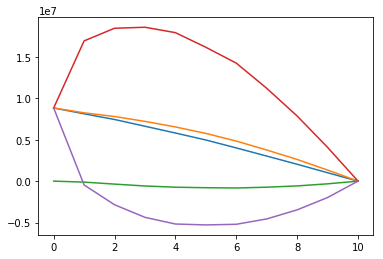

In [25]:
ee = np.mean(all_paths, axis = 0)
epe = np.mean(np.clip(all_paths, 0, None), axis = 0)
ene = np.mean(np.clip(all_paths, None, 0), axis = 0)
p95 = np.percentile(all_paths, 95, axis = 0)
p05 = np.percentile(all_paths, 5, axis = 0)

#print some lines
print(ee)
print(epe)
print(ene)

#plot some lines
plt.plot(ee)
plt.plot(epe)
plt.plot(ene)
plt.plot(p95)
plt.plot(p05)
plt.show()